In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass
from hmmlearn import hmm
from functions import *
from random import shuffle
from random import seed
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

### Loading the data

In [2]:
df = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized.txt')
df_scores = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_data_anonymized.txt')
df["student"] = df["student"].astype('category')
df_scores["student"] = df_scores["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()

def remodel_families(row):
    if row["Family"] == "Build" or row["Family"] == "Revise" or row["Family"] == "Extra":
        if row["Outcome"] != "None":
            return "ConstructWithFeedback"
        else:
            return "Construct"
    else:
        return row["Family"]
    
df['Family'] = df.apply (lambda row: remodel_families (row),axis=1)

### Some parameters

In [29]:
ACTIONS_TO_REMOVE = ['I','O','S','E']
ITERS = 300
RAND_INT = 2
seed(RAND_INT)

### Declaring a few functions

In [44]:
def get_model(X,lengths,n_states, iters=ITERS, random_state=RAND_INT):
    '''Note that all integers in the range of observations must be present in the data!!'''
    converged = False
    tries = 0
    while converged == False:
        model = hmm.MultinomialHMM(n_components=n_states,
                            n_iter = iters,
                            random_state = random_state).fit(X,lengths)
        converged = model.monitor_.converged
        tries += 1
    print "Model with {0} hidden states converged after {1} tries, with {2} iterations".format(n_states, tries, model.monitor_.iter)
    return model

### Modelling
#### Getting the data
 First, we get the student actions in blocks and keep only the actions we care about. We also build a translator and decoder to pass the actions as discreet integers instead of strings

In [7]:
blocks = get_blocks(df,get_students(),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
events = [e for e in ["T","S","O","F","P","I","E","X","C",] if e not in ACTIONS_TO_REMOVE]
translater = {e:events.index(e) for e in events}
decoder = {events.index(e):e for e in events}
events

['T', 'F', 'P', 'X', 'C']

We concatenate the student actions into one array and computer their lengths

In [8]:
shuffled_blocks = blocks.values()
shuffle(shuffled_blocks)
X = np.array( np.array([np.concatenate([  [int(translater[event]) for event in block.split(' ')] for block in shuffled_blocks])]).T )
lengths = [len(b.split(' ')) for b in blocks.values()]

#### Formatting the data for cross validation
We split the data into a training and test set using a 60/40 % split

In [9]:
n_train = int(len(lengths)*0.6)
n_test = len(lengths) - n_train
lengths_train, lengths_test = lengths[0:n_test], lengths[n_test:]
X_train, X_test = X[0:sum(lengths_train)], X[sum(lengths_train):]

We produce the model with the train set using different number of hidden states

In [67]:
scores = []
models = []
n_states = range(1,len(events)+3)
print "Computing HMM model for 39 samples of observations"
for n in n_states:
    model = get_model(X_train, lengths_train, n)
    scores.append(model.score(X_test, lengths = lengths_test))
    models.append(model)

Computing HMM model for 39 samples of observations
HMM Model with 1 hidden states converged after 1 tries, with 3 iterations
HMM Model with 2 hidden states converged after 1 tries, with 100 iterations
HMM Model with 3 hidden states converged after 1 tries, with 78 iterations
HMM Model with 4 hidden states converged after 1 tries, with 75 iterations
HMM Model with 5 hidden states converged after 1 tries, with 77 iterations
HMM Model with 6 hidden states converged after 1 tries, with 169 iterations
HMM Model with 7 hidden states converged after 1 tries, with 158 iterations


#### Now we can plot the scores

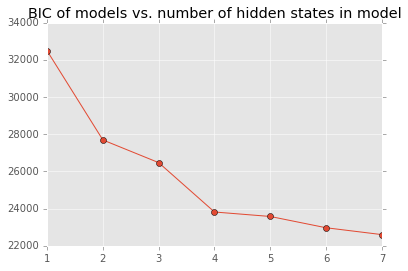

In [68]:
bics = [-2*L + k*np.log(len(X_train)) for L,k in zip(scores, n_states)]
plt.plot(n_states, bics,'-o')
plt.title("BIC of models vs. number of hidden states in model")

### Analysis of model
Given that we want to trade off between the number of hidden states and the information gained, we pick the number of hidden states as 4 (which is where there is an elbow in the plot above). We store the transition and emition probabilities and visualize them.

In [139]:
N = 4
model = models[N-1]
G = nx.MultiDiGraph()
G.add_nodes_from(events, node_type = "event")
G.add_nodes_from(range(N), node_type = "state")

#Adding edge between hidden states
for (i,j), p in np.ndenumerate(model.transmat_):
    G.add_edge(i,j, weight = p, label="{:.02f}".format(p))

#Adding emission probabilities: from hidden state to observation
for (i,j), p in np.ndenumerate(model.emissionprob_):
     G.add_edge(i,decoder[j], weight = p, label="{:.02f}".format(p))

#Can add starting probs eventually

0 0 {0: {'weight': 4.6270936296518912e-13, 'label': '0.00'}}
0 1 {0: {'weight': 0.024740191782998539, 'label': '0.02'}}
0 2 {0: {'weight': 0.12530148274808078, 'label': '0.13'}}
0 3 {0: {'weight': 0.84995832546845784, 'label': '0.85'}}
0 F {0: {'weight': 2.6067200270035138e-78, 'label': '0.00'}}
0 C {0: {'weight': 0.99881665559153932, 'label': '1.00'}}
0 P {0: {'weight': 0.0011832105249644073, 'label': '0.00'}}
0 T {0: {'weight': 1.3388349631294705e-07, 'label': '0.00'}}
0 X {0: {'weight': 2.4071610119062363e-34, 'label': '0.00'}}
1 0 {0: {'weight': 0.16030678581184385, 'label': '0.16'}}
1 1 {0: {'weight': 3.7235139670502405e-26, 'label': '0.00'}}
1 2 {0: {'weight': 0.5551701156558011, 'label': '0.56'}}
1 3 {0: {'weight': 0.28452309853235508, 'label': '0.28'}}
1 F {0: {'weight': 2.1845772819535046e-21, 'label': '0.00'}}
1 C {0: {'weight': 0.10589467131940487, 'label': '0.11'}}
1 P {0: {'weight': 0.89040523760598767, 'label': '0.89'}}
1 T {0: {'weight': 1.1181379720831153e-36, 'label': 

(-10.0, 10.0, -1.0, 6.0)

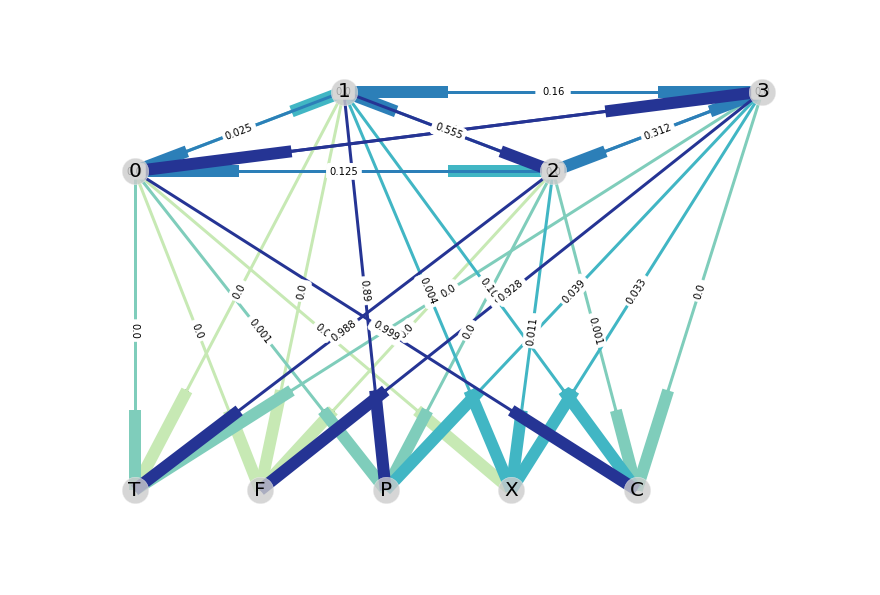

In [140]:
fig = plt.figure(figsize=(15,10))
pos = {n:np.array([ (n-np.max(range(N))/2.0)/np.max(range(N))*15 ,4+n%2]) for n in range(N)}
pos.update({e:np.array([   (i-np.max(len(events))/2.0)/np.max(len(events))*15   ,0]) for i,e in enumerate(events)})
nx.draw_networkx_nodes(G,pos,node_size=700,node_color='#cccccc',alpha=0.8)
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels={(k[0],k[1]):round(v,3) for k,v in labels.iteritems()})
nx.draw_networkx_edges(G,pos)

cut1 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 20)
cut2 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 40)
cut3 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 60)
cut4 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 80)

esmall = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= cut1]
emedium = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut1 and d['weight'] <= cut2]
elarge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut2 and d['weight'] <= cut3]
ehuge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut3 and d['weight'] <= cut4]
enormous = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut4]

colors = ["#c7e9b4","#7fcdbb","#41b6c4","#2c7fb8","#253494"]
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=3,alpha=1,arros=True,edge_color=colors[0])
nx.draw_networkx_edges(G,pos,edgelist=emedium,width=3,alpha=1,arros=True,edge_color=colors[1])
nx.draw_networkx_edges(G,pos,edgelist=elarge,width=3,alpha=1,arros=True,edge_color=colors[2])
nx.draw_networkx_edges(G,pos,edgelist=ehuge,width=3,alpha=1,arros=True,edge_color=colors[3])
nx.draw_networkx_edges(G,pos,edgelist=enormous,width=3,alpha=1,arros=True,edge_color=colors[4])

plt.axis('off')

Unfortunately, seems like having 4 hidden states creates a pretty boring HMM: each states produces one of the main actions with 0.9 prob or more. So let's go back to 3 states and see what that gives us.

In [141]:
N = 3
model = models[N-1]
G = nx.MultiDiGraph()
G.add_nodes_from(events, node_type = "event")
G.add_nodes_from(range(N), node_type = "state")

#Adding edge between hidden states
for (i,j), p in np.ndenumerate(model.transmat_):
    G.add_edge(i,j, weight = p, label="{:.02f}".format(p))

#Adding emission probabilities: from hidden state to observation
for (i,j), p in np.ndenumerate(model.emissionprob_):
     G.add_edge(i,decoder[j], weight = p, label="{:.02f}".format(p))

#Can add starting probs eventually

0 0 {0: {'weight': 6.7437362704415979e-05, 'label': '0.00'}}
0 1 {0: {'weight': 0.094892080680816129, 'label': '0.09'}}
0 2 {0: {'weight': 0.90504048195647946, 'label': '0.91'}}
0 F {0: {'weight': 1.4008822110239361e-78, 'label': '0.00'}}
0 C {0: {'weight': 0.94770182720393392, 'label': '0.95'}}
0 P {0: {'weight': 0.00091665582588522018, 'label': '0.00'}}
0 T {0: {'weight': 0.051381516970180785, 'label': '0.05'}}
0 X {0: {'weight': 5.6543840304643941e-40, 'label': '0.00'}}
1 0 {0: {'weight': 0.19871965092819349, 'label': '0.20'}}
1 1 {0: {'weight': 0.48462617104738825, 'label': '0.48'}}
1 2 {0: {'weight': 0.31665417802441831, 'label': '0.32'}}
1 F {0: {'weight': 3.3357025379664068e-24, 'label': '0.00'}}
1 C {0: {'weight': 0.014115837237778203, 'label': '0.01'}}
1 P {0: {'weight': 0.43953062831728817, 'label': '0.44'}}
1 T {0: {'weight': 0.52245892395356641, 'label': '0.52'}}
1 X {0: {'weight': 0.023894610491367232, 'label': '0.02'}}
2 0 {0: {'weight': 0.60586337051927486, 'label': '0.6

(-10.0, 10.0, -1.0, 6.0)

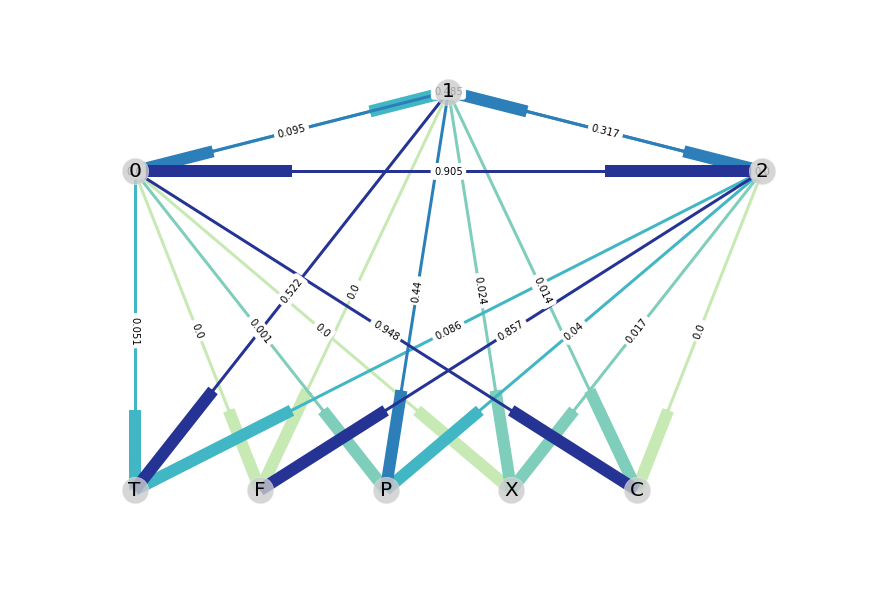

In [142]:
fig = plt.figure(figsize=(15,10))
pos = {n:np.array([ (n-np.max(range(N))/2.0)/np.max(range(N))*15 ,4+n%2]) for n in range(N)}
pos.update({e:np.array([   (i-np.max(len(events))/2.0)/np.max(len(events))*15   ,0]) for i,e in enumerate(events)})
nx.draw_networkx_nodes(G,pos,node_size=700,node_color='#cccccc',alpha=0.8)
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels={(k[0],k[1]):round(v,3) for k,v in labels.iteritems()})
nx.draw_networkx_edges(G,pos)

cut1 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 20)
cut2 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 40)
cut3 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 60)
cut4 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 80)

esmall = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= cut1]
emedium = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut1 and d['weight'] <= cut2]
elarge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut2 and d['weight'] <= cut3]
ehuge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut3 and d['weight'] <= cut4]
enormous = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut4]

colors = ["#c7e9b4","#7fcdbb","#41b6c4","#2c7fb8","#253494"]
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=3,alpha=1,arros=True,edge_color=colors[0])
nx.draw_networkx_edges(G,pos,edgelist=emedium,width=3,alpha=1,arros=True,edge_color=colors[1])
nx.draw_networkx_edges(G,pos,edgelist=elarge,width=3,alpha=1,arros=True,edge_color=colors[2])
nx.draw_networkx_edges(G,pos,edgelist=ehuge,width=3,alpha=1,arros=True,edge_color=colors[3])
nx.draw_networkx_edges(G,pos,edgelist=enormous,width=3,alpha=1,arros=True,edge_color=colors[4])

plt.axis('off')

(-1.0, 1.5, -1.5, 1.5)

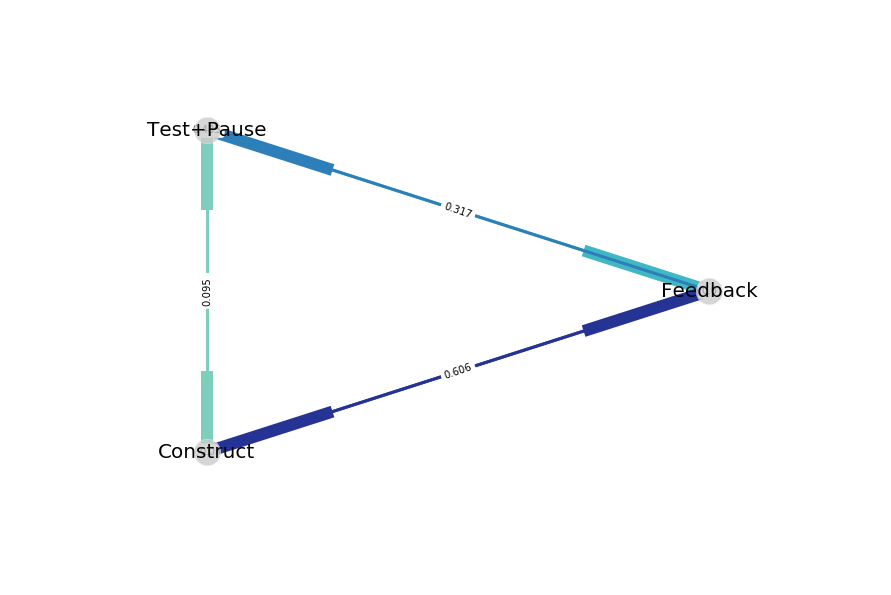

In [143]:
#Alright so we can now assign names to states. Now let's plot only the states
G.remove_nodes_from(events)
G = nx.relabel_nodes(G,mapping= {0:"Construct", 1:"Test+Pause",2:"Feedback"})
fig = plt.figure(figsize=(15,10))
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=700,node_color='#cccccc',alpha=0.8)
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels={(k[0],k[1]):round(v,3) for k,v in labels.iteritems()})

cut1 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 20)
cut2 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 40)
cut3 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 60)
cut4 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 80)

esmall = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= cut1]
emedium = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut1 and d['weight'] <= cut2]
elarge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut2 and d['weight'] <= cut3]
ehuge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut3 and d['weight'] <= cut4]
enormous = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut4]

colors = ["#c7e9b4","#7fcdbb","#41b6c4","#2c7fb8","#253494"]
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=3,alpha=1,arros=True,edge_color=colors[0])
nx.draw_networkx_edges(G,pos,edgelist=emedium,width=3,alpha=1,arros=True,edge_color=colors[1])
nx.draw_networkx_edges(G,pos,edgelist=elarge,width=3,alpha=1,arros=True,edge_color=colors[2])
nx.draw_networkx_edges(G,pos,edgelist=ehuge,width=3,alpha=1,arros=True,edge_color=colors[3])
nx.draw_networkx_edges(G,pos,edgelist=enormous,width=3,alpha=1,arros=True,edge_color=colors[4])

plt.axis('off')